In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from loader_util.preprocessing import AspectAwarePreprocessor, ImageToArrayPreprocessor
from loader_util.datasets import SimpleDatasetLoader
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from loader_util.nn.conv import LeNet
from imutils import paths
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes._axes as axes
import cv2
import os
sns.set()

In [16]:
dataFolder = r"C:\Users\mhasa\Google Drive\Tutorial Corner\PYTH\DeepLearning\DeepLearning-DL4CV\ImageDatasets\cellImages"

args = {
    'dataset': dataFolder
}

imagePaths = list(paths.list_images(args['dataset']))

In [17]:
# initialise the preprocessors
sp = AspectAwarePreprocessor(64, 64)
iap = ImageToArrayPreprocessor()

# load the dataset
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
data, labels = sdl.load(imagePaths, verbose=100)
data = data.astype('float') / 255.0

[INFO] processed 100/725
[INFO] processed 200/725
[INFO] processed 300/725
[INFO] processed 400/725
[INFO] processed 500/725
[INFO] processed 600/725
[INFO] processed 700/725


In [9]:
# data_gray = []
# 
# for ind, processed_image in enumerate(data):
#     gray = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
#     gray = img_to_array(gray)
#     #print(processed_image.shape)
#     #print(gray.shape)
#     data_gray.append(gray)
# data_gray = np.array(data_gray)
# data = data_gray.astype('float') / 255.0 # scale image to 0-1

In [18]:
le = LabelEncoder().fit(labels)
labels = to_categorical(le.transform(labels), 2)
trainx, testx, trainy, testy = train_test_split(data, labels, test_size=0.1,
                                                random_state=42, stratify=labels)

# imbalance
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [19]:
epoch_no = 300
opt = SGD(learning_rate=0.005)
model = LeNet.build(width=64, height=64, depth=3, classes=2)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
H = model.fit(trainx,
              trainy, validation_data=[testx, testy],
              batch_size=10,
              epochs=epoch_no,
              verbose=1,
              class_weight=classWeight)

Train on 652 samples, validate on 73 samples
Epoch 1/300
652/652 [==============================] - 2s 3ms/sample - loss: 0.6705 - accuracy: 0.6089 - val_loss: 0.6696 - val_accuracy: 0.6301

In [20]:
# evaluate the network
preds = model.predict(testx, batch_size=10)
rep = classification_report(testy.argmax(axis=1), preds.argmax(axis=1), 
                            target_names=le.classes_)
print(rep)

              precision    recall  f1-score   support

         3T3       0.96      0.93      0.95        46
        MG63       0.89      0.93      0.91        27

    accuracy                           0.93        73
   macro avg       0.92      0.93      0.93        73
weighted avg       0.93      0.93      0.93        73



In [21]:
epochs = range(1,epoch_no+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy], 
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

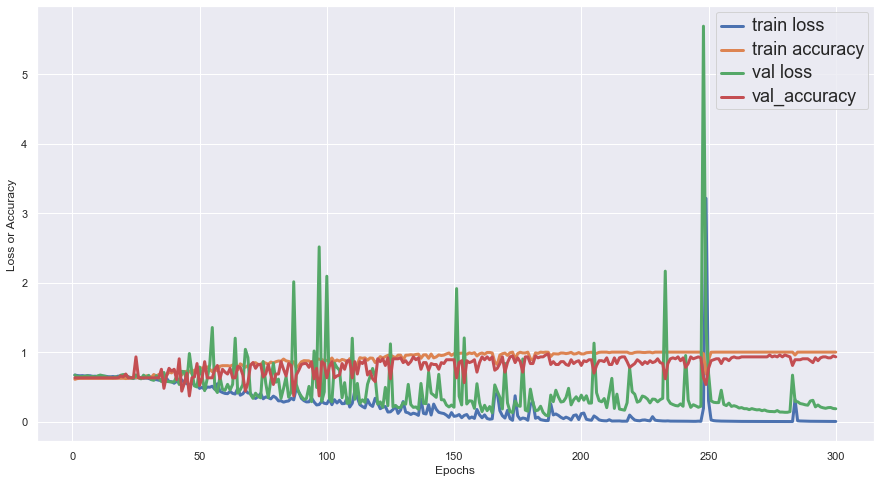

In [22]:
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [23]:
model.save('./checkpoint')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./checkpoint\assets
